<a href="https://colab.research.google.com/github/eebjwa/SENSE_GEE_TEAM3/blob/main/eszters_experiment_bry_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set up session
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=rMJbQJfrrMSumB_--qtTNYd54n1gr9e0LAPAJA82O5A&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/5gHnBQptFHu8dZY4QBJe0GnX2klryS71tO4iyVOhnrcHZO3Pw4eWNdY

Successfully saved authorization token.


Open some dataset in Hispaniola


In [2]:
zoomed_out =  ee.Geometry.Polygon(
        [[[-74.60668900677238, 20.088333497505946],
          [-74.60668900677238, 17.687361057873034],
          [-68.11376908489738, 17.687361057873034],
          [-68.11376908489738, 20.088333497505946]]])
zoomed_in =  ee.Geometry.Polygon(
        [[[-71.7976970344606, 19.335441167371748],
          [-71.7976970344606, 19.19316176101097],
          [-71.60268971024185, 19.19316176101097],
          [-71.60268971024185, 19.335441167371748]]])

collection = ee.ImageCollection('MODIS/006/MOD44B').filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)#.filterBounds(zoomed_out).filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)
veg2019 = collection.filterDate('2019-01-01', '2019-12-31').first()
veg2018 = collection.filterDate('2018-01-01', '2018-12-31').first()
veg2000 = collection.filterDate('2000-01-01', '2000-12-31').first()

Put all of these on a map (reference)


In [3]:
import folium
!pip install geehydro
import geehydro

  Created wheel for geehydro: filename=geehydro-0.2.0-py2.py3-none-any.whl size=10114 sha256=c4c4b8ab79062f1aee9b397eb18a2aa121ed92e36899930633c0cfbf9e6b2f25
  Stored in directory: /root/.cache/pip/wheels/c5/07/67/5fa6e7271b46bbe0acafdc7105bbee27a39ab7132d251d822d
Successfully built geehydro


In [4]:
# Use folium to visualize the imagery.
map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(veg2000, {'gain':2},'2000')
map.addLayer(veg2019, {'gain':2}, '2019')
map.addLayer(veg2018, {'gain':2},'2018')
folium.LayerControl().add_to(map)
map

Plot cumulative differences in vegetation(ignore this bit because I abandoned the idea)




In [ ]:
collectionNonVeg = collection.filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False).select('Percent_NonVegetated')

Check that collection still contains data (ignore this bit because I abandoned the idea)



In [ ]:
map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(collectionNonVeg.first(), {'gain':2},'nonVeg')
folium.LayerControl().add_to(map)
map

In [5]:
mean = collectionNonVeg.mean()

def subtracting(image):
  return image.subtract(mean).set('system:time_start', image.get('system:time_start'))

series = collectionNonVeg.map(subtracting)
series_sum = series.sum()

map = folium.Map(location = [18.999768, -71.374124], zoom_start=8)
map.addLayer(series_sum, {'gain':2},'Cumulative difference in non-vegetation')
folium.LayerControl().add_to(map)
map

NameError: ignored

TIME SERIES (and it works!)

In [44]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams

# List of used image bands
band_list = ['Percent_Tree_Cover', 'Percent_NonTree_Vegetation', 'Percent_NonVegetated']

collection = ee.ImageCollection('MODIS/006/MOD44B').select(band_list)#.filterBounds(point)#.filterBounds(zoomed_out).filterDate('2000-01-01', '2019-12-31').sort('system:time_start', False)

count = collection.size()
#print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get info from the point
info = collection.getRegion(geometry=zoomed_out, scale=20000).getInfo()    #.filterBounds(zoomed_out).getInfo() # change colelction by series

#print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)
print(yData.shape) #tells us there are 10080 rows and 3 columns (tree, non-tree-veg, non-veg)

'''THIS WAS WHERE THE ISSUE WAS - you had just extracted the yData from a single column 
into the variable 'trees' that you then used as the input to all of the subsequent pandas dataframe, 
so it was simply entering the same data (for trees only) to your dataframes for all three categories '''
trees = yData[:,0] #tree cover
non_tree_veg = yData[:,1] #non-tree veg
non_veg = yData[:,2] #non-veg

# Reshape tree array into Pandas Dataframe
dfTC = pd.DataFrame(data=trees, columns=['Tree Cover (%)'])
dfTC['time'] = pd.Series(time, index=dfTC.index)

# get mean value for every year
groupTC =dfTC.groupby(['time']).mean()
print(groupTC.head())


# Do same for non-tree vegetation
dfNT = pd.DataFrame(data=non_tree_veg, columns=['Non-Tree Vegetation (%)'])
dfNT['time'] = pd.Series(time, index=dfNT.index)
groupNT =dfNT.groupby(['time']).mean()
print(groupNT.head())

# Do same for non-vegetated
dfNV = pd.DataFrame(data=non_veg, columns=['Non-Vegetated (%)'])
dfNV['time'] = pd.Series(time, index=dfNV.index)
groupNV =dfNV.groupby(['time']).mean()
print(groupNV.head())



#print(df['time'])
#print(groupTC['Percent_Tree_Cover'])

(10080, 3)
            Tree Cover (%)
time                      
2000-03-05       29.287879
2001-03-06       27.613636
2002-03-06       27.935606
2003-03-06       30.204545
2004-03-05       29.689394
            Non-Tree Vegetation (%)
time                               
2000-03-05                55.806818
2001-03-06                56.075758
2002-03-06                58.446970
2003-03-06                55.257576
2004-03-05                55.621212
            Non-Vegetated (%)
time                         
2000-03-05          16.640152
2001-03-06          18.026515
2002-03-06          15.299242
2003-03-06          16.306818
2004-03-05          16.454545


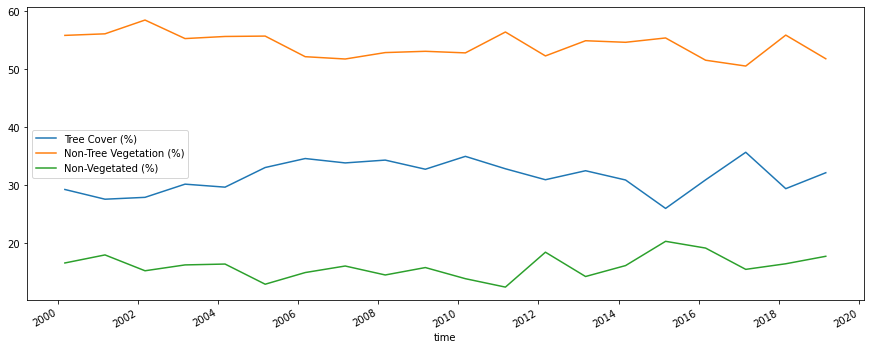

In [43]:
# Plotting

rcParams['figure.figsize'] = 15, 6
ax = groupTC.plot()
groupNT.plot(ax=ax)
groupNV.plot(ax=ax)
plt.show()
